In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/mouse_snrna_all_soupX_unfil_0524.rds')

seurat



An object of class Seurat 
47910 features across 195367 samples within 1 assay 
Active assay: RNA (47910 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


 2191-1 2191-10  2191-2  2191-3  2191-4  2191-5  2191-6  2191-7  2191-8  2191-9 
   7766    7624    7744    7652    7694    7899    7477    7484    7464    7717 
 2350-1 2350-10 2350-11 2350-12 2350-13 2350-14 2350-15 2350-16  2350-2  2350-3 
   7254    7465    7314    7491    7521    7531    7418    7524    7399    7304 
 2350-4  2350-5  2350-6  2350-7  2350-8  2350-9 
   7267    7424    7476    7400    7566    7492 

[1] 26

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)




[1] 26

character(0)

[1] 26

In [5]:
seurat

An object of class Seurat 
47910 features across 195367 samples within 1 assay 
Active assay: RNA (47910 features, 0 variable features)

In [6]:
libMetaTb = read_xlsx(paste0(
    "/home/liuyx/liuyuxuan/spa_seurat/cla", 
    "/sample_lib_meta.xlsx"
))
libMetaTb=libMetaTb[,c('tissue','sampleID')]
colnames(libMetaTb)=c('sampleId','sampleID')
libMetaTb$libId=str_extract(libMetaTb$sampleID,'[0-9][0-9][0-9][0-9]-[0-9]')
libMetaTb$sampleID=NULL
libMetaTb=libMetaTb[!(is.na(libMetaTb$libId)),]
head(libMetaTb)

New names:
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`


sampleId,libId
<chr>,<chr>
Cla-rostral,6103-1
Cla-rostral,6103-2
Cla-rostral,6103-3
Cla-rostral,6103-4
Cla-rostral,6103-5
Cla-rostral,6103-6


In [7]:
seurat@meta.data$libId=seurat@meta.data$group

tmpMetaTb = as_tibble(seurat@meta.data[c("libId")])
tmpMetaTb$cellId = rownames(seurat@meta.data)
tmpMetaTb = left_join(tmpMetaTb, libMetaTb[c("sampleId", "libId")], by="libId")
tmpMetaTb = column_to_rownames(tmpMetaTb, var="cellId")
identical(rownames(tmpMetaTb), rownames(seurat@meta.data))
# str(tmpMetaTb)
seurat = AddMetaData(seurat, tmpMetaTb)
seurat$sampleId = factor(seurat$sampleId)
seurat$libId = factor(seurat$libId)

setdiff(libMetaTb$libId, unique(seurat$libId))
length(setdiff(libMetaTb$libId, unique(seurat$libId)))




[1] TRUE

[1] "6103-1" "6103-2" "6103-3" "6103-4" "6103-5" "6103-6" "6712-1" "6712-2"
 [9] "6712-3" "6712-4" "6708-1" "6708-2" "6708-3" "6708-4" "7220-1" "7220-2"
[17] "7221-1" "7221-2" "7222-1" "7222-2" "7223-1" "7223-2" "7224-1" "7224-2"
[25] "7230-1" "7230-2" "7231-1" "7231-2" "7231-3" "7232-1" "7232-2" "7232-3"
[33] "7248-1" "7248-2"

[1] 34

In [8]:
MTGenes = rownames(seurat)[grep('mt',rownames(seurat))]
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,pattern = MTGenes)




Warning message in grep(pattern = pattern, x = rownames(x = object[[assay]]), value = TRUE):
“argument 'pattern' has length > 1 and only the first element will be used”


In [9]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)

[1] 195367

Filter ratio: 1



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


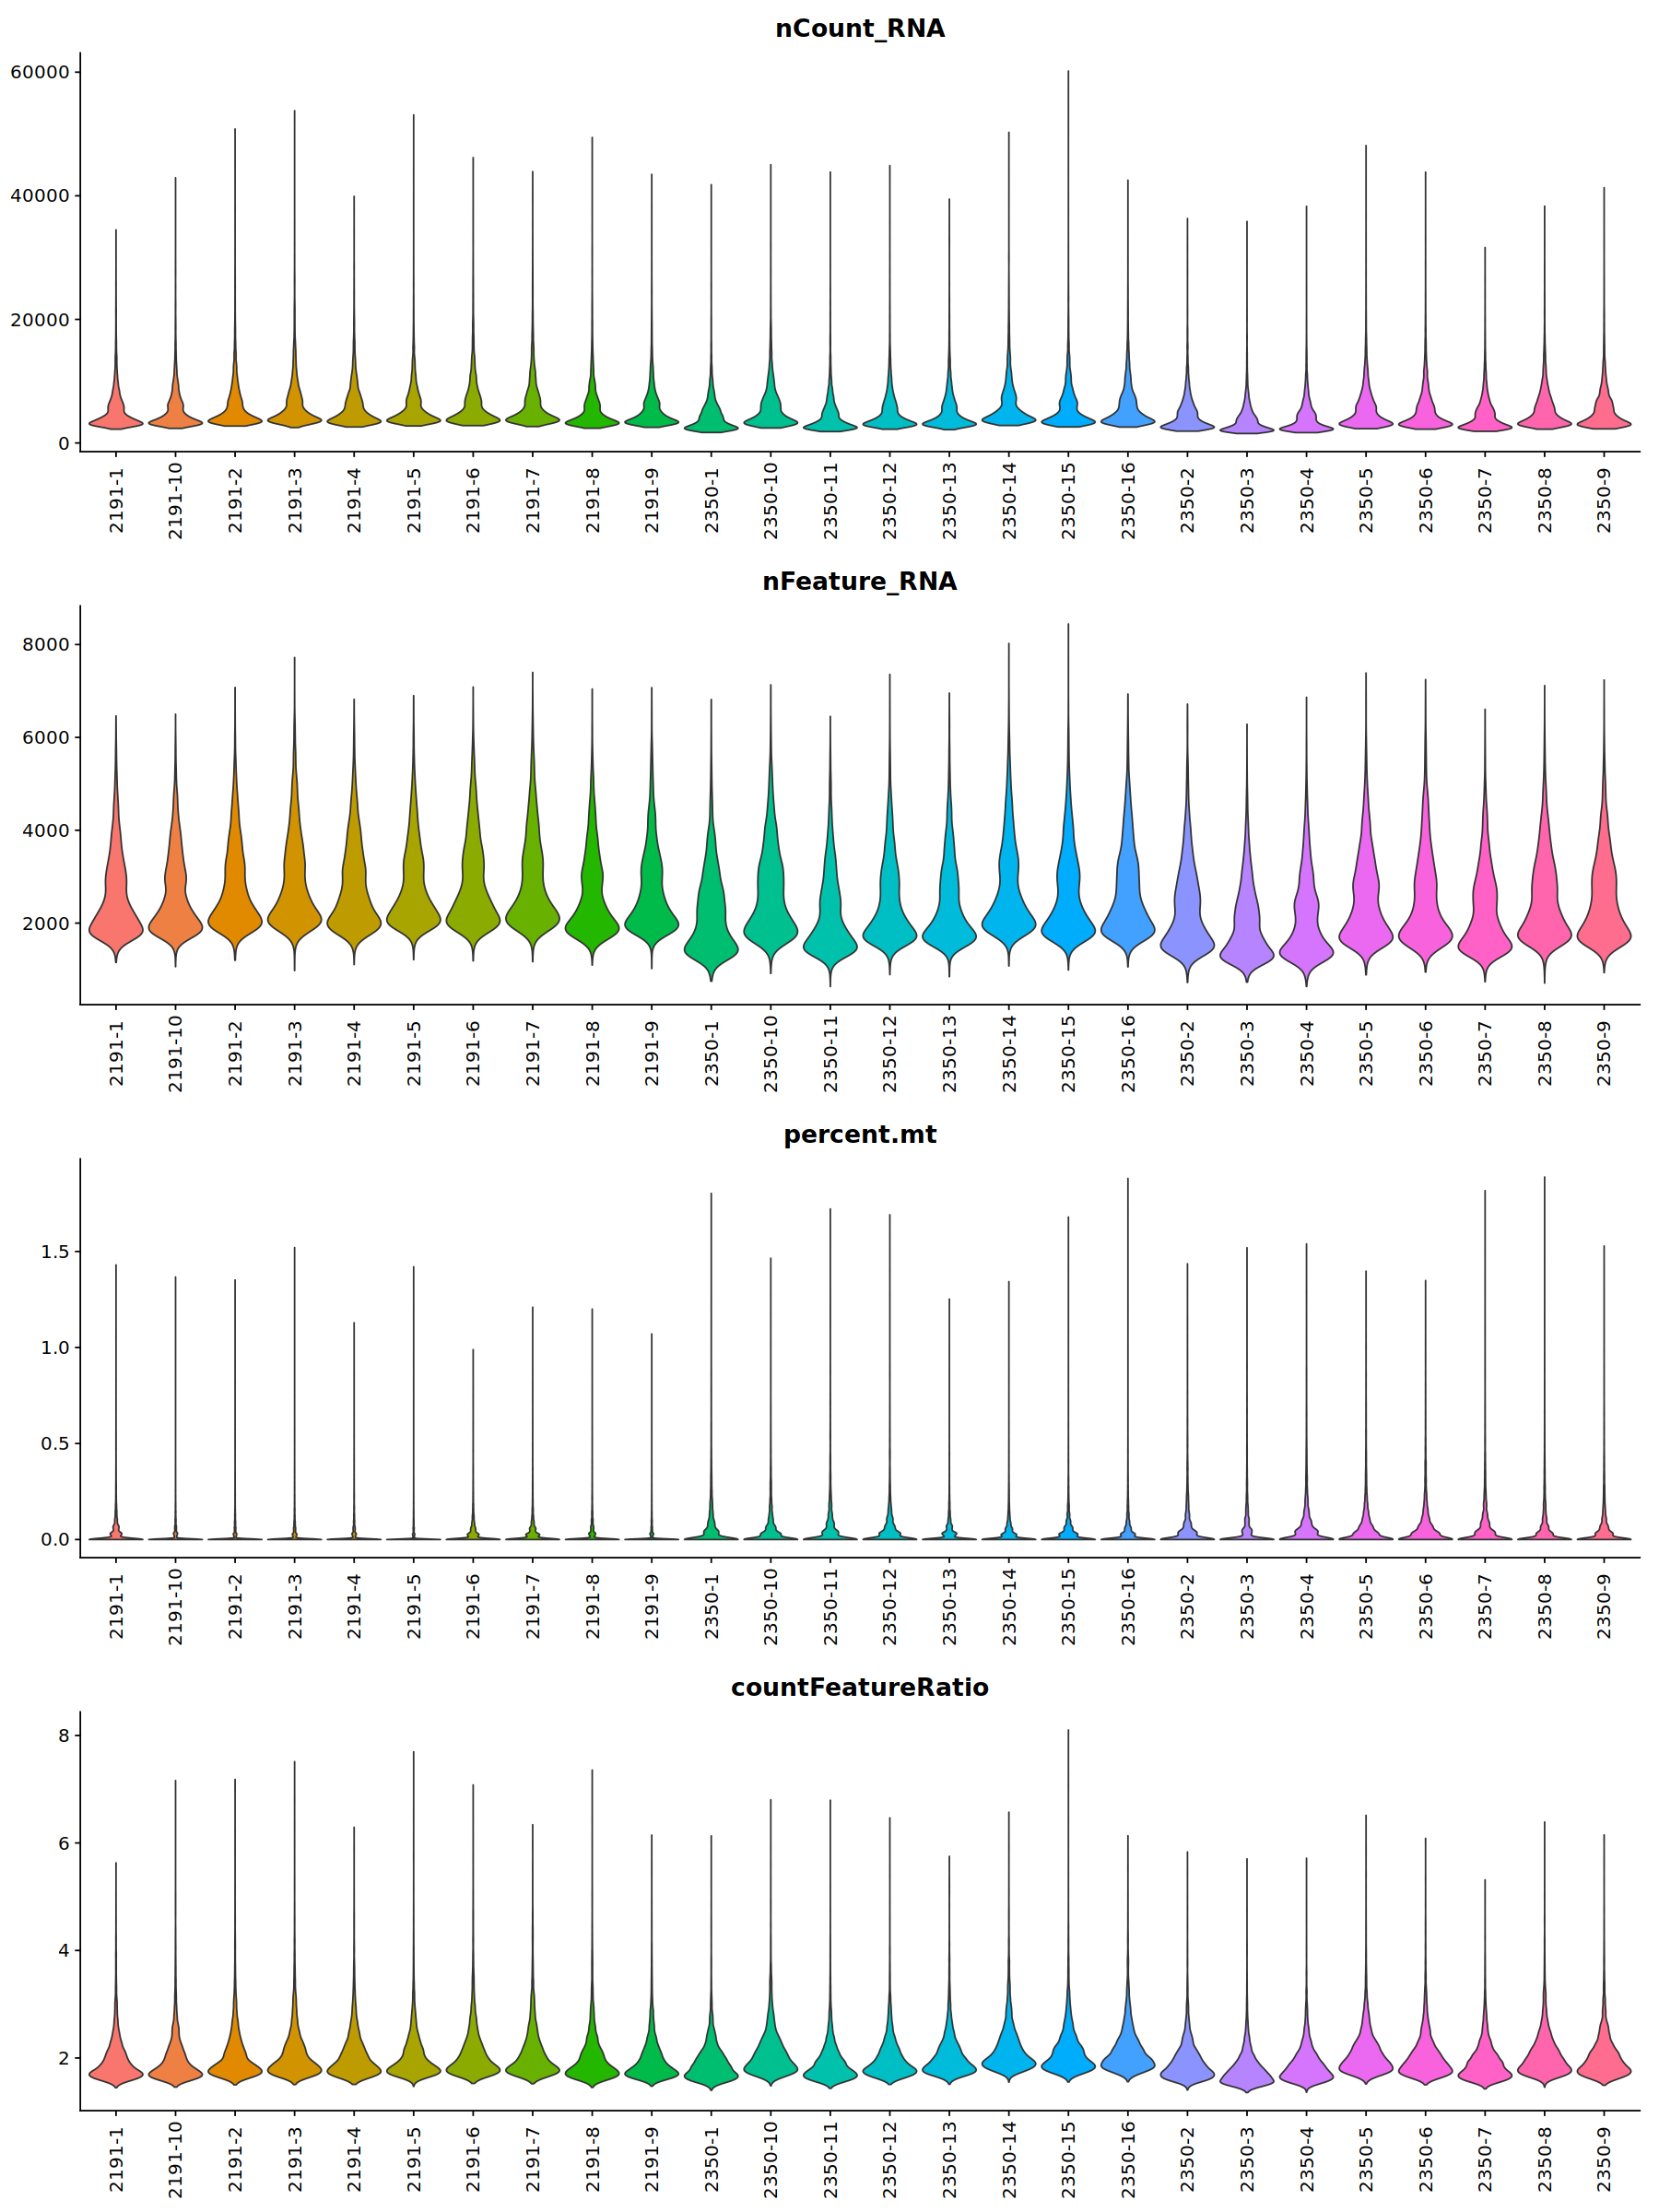

In [10]:
Idents(seurat) = "libId"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

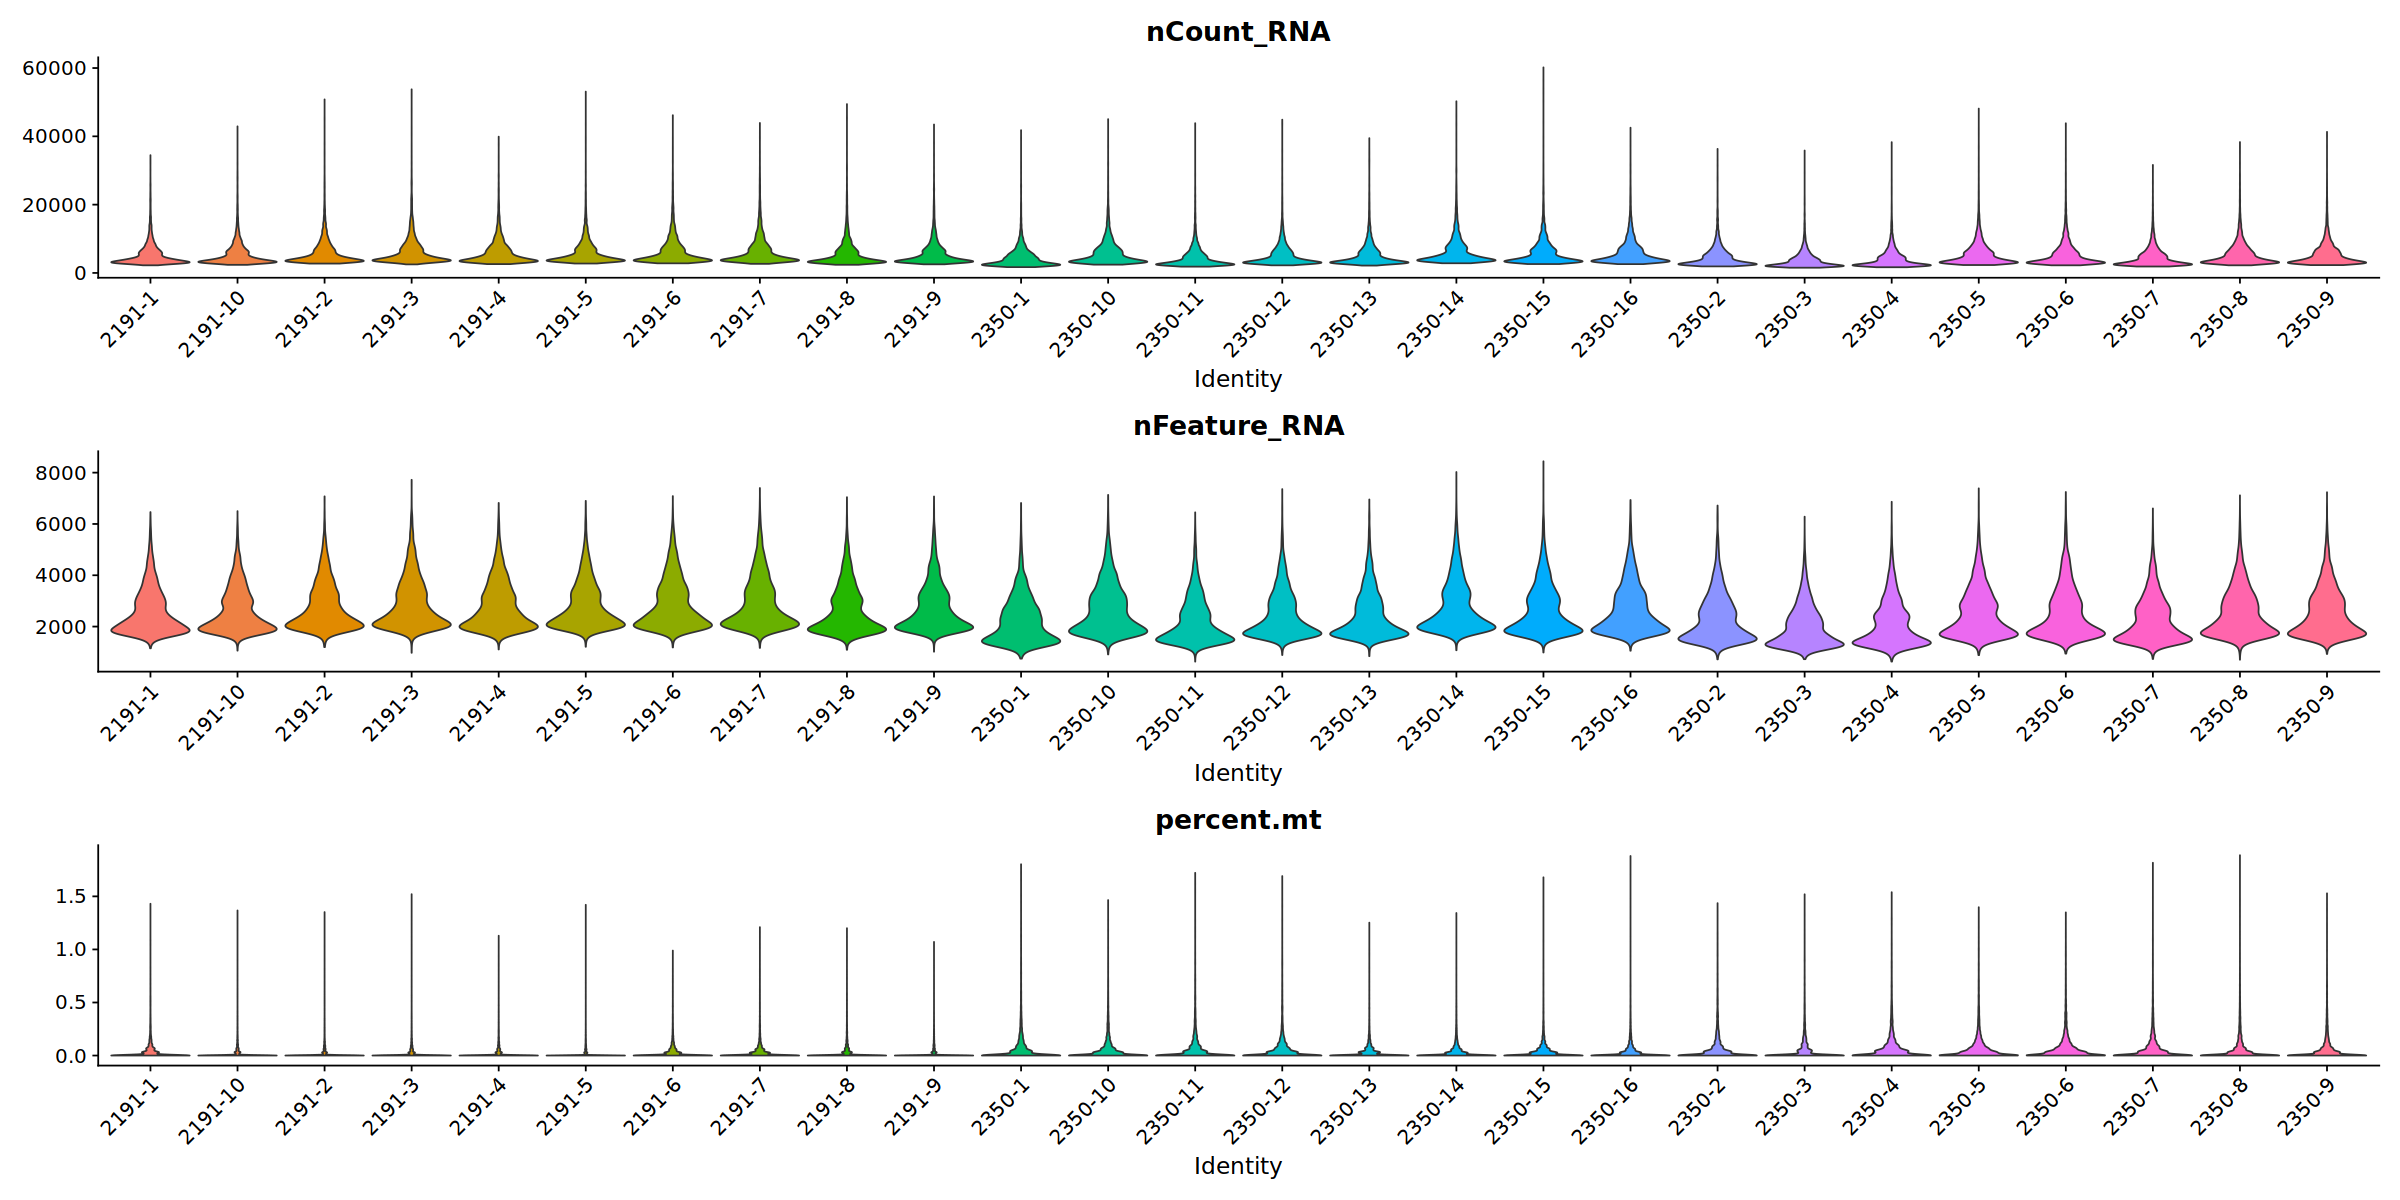

In [11]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "libId"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)




In [12]:
seurat

An object of class Seurat 
47910 features across 195367 samples within 1 assay 
Active assay: RNA (47910 features, 0 variable features)

In [13]:
#更新为统一版本

saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse/mouse_snrna_all_soupX_fil_batch1_0524.rds')



In [14]:
#原有不统一版本

saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/mouse_snrna_all_soupX_fil_0524.rds')



In [16]:
# Do sct together
seurat = SCTransform(
    seurat, assay="RNA",
    ncells=ncol(seurat[["RNA"]]), 
    variable.features.n=5000,
#         vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
) 
seurat = seurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)
options(repr.plot.width=6, repr.plot.height=2.5)
ElbowPlot(seurat, reduction = "pca", ndims=50)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 41361 by 195367

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 195367 cells



  |                                                                      |   0%

In [10]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/mouse_snrna_all_soupX_fil800_SCT_0524.rds')


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



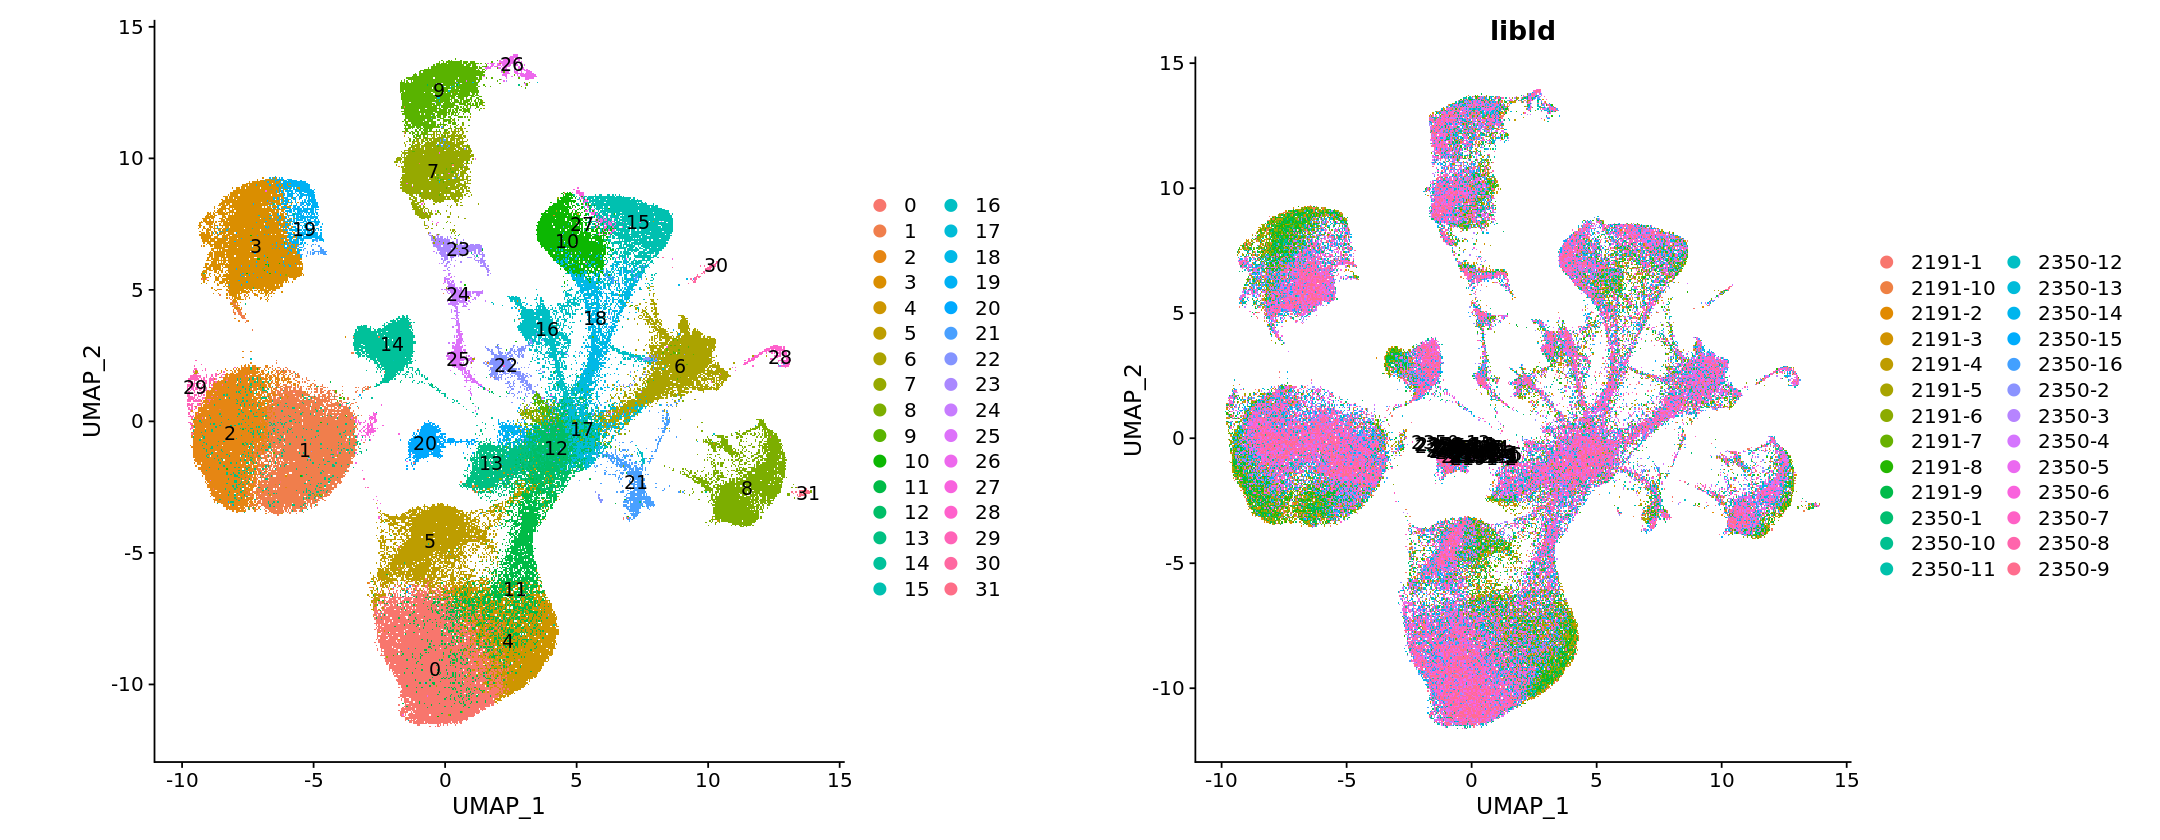

In [12]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="libId", label=T)+coord_fixed(),
    nrow=1
)

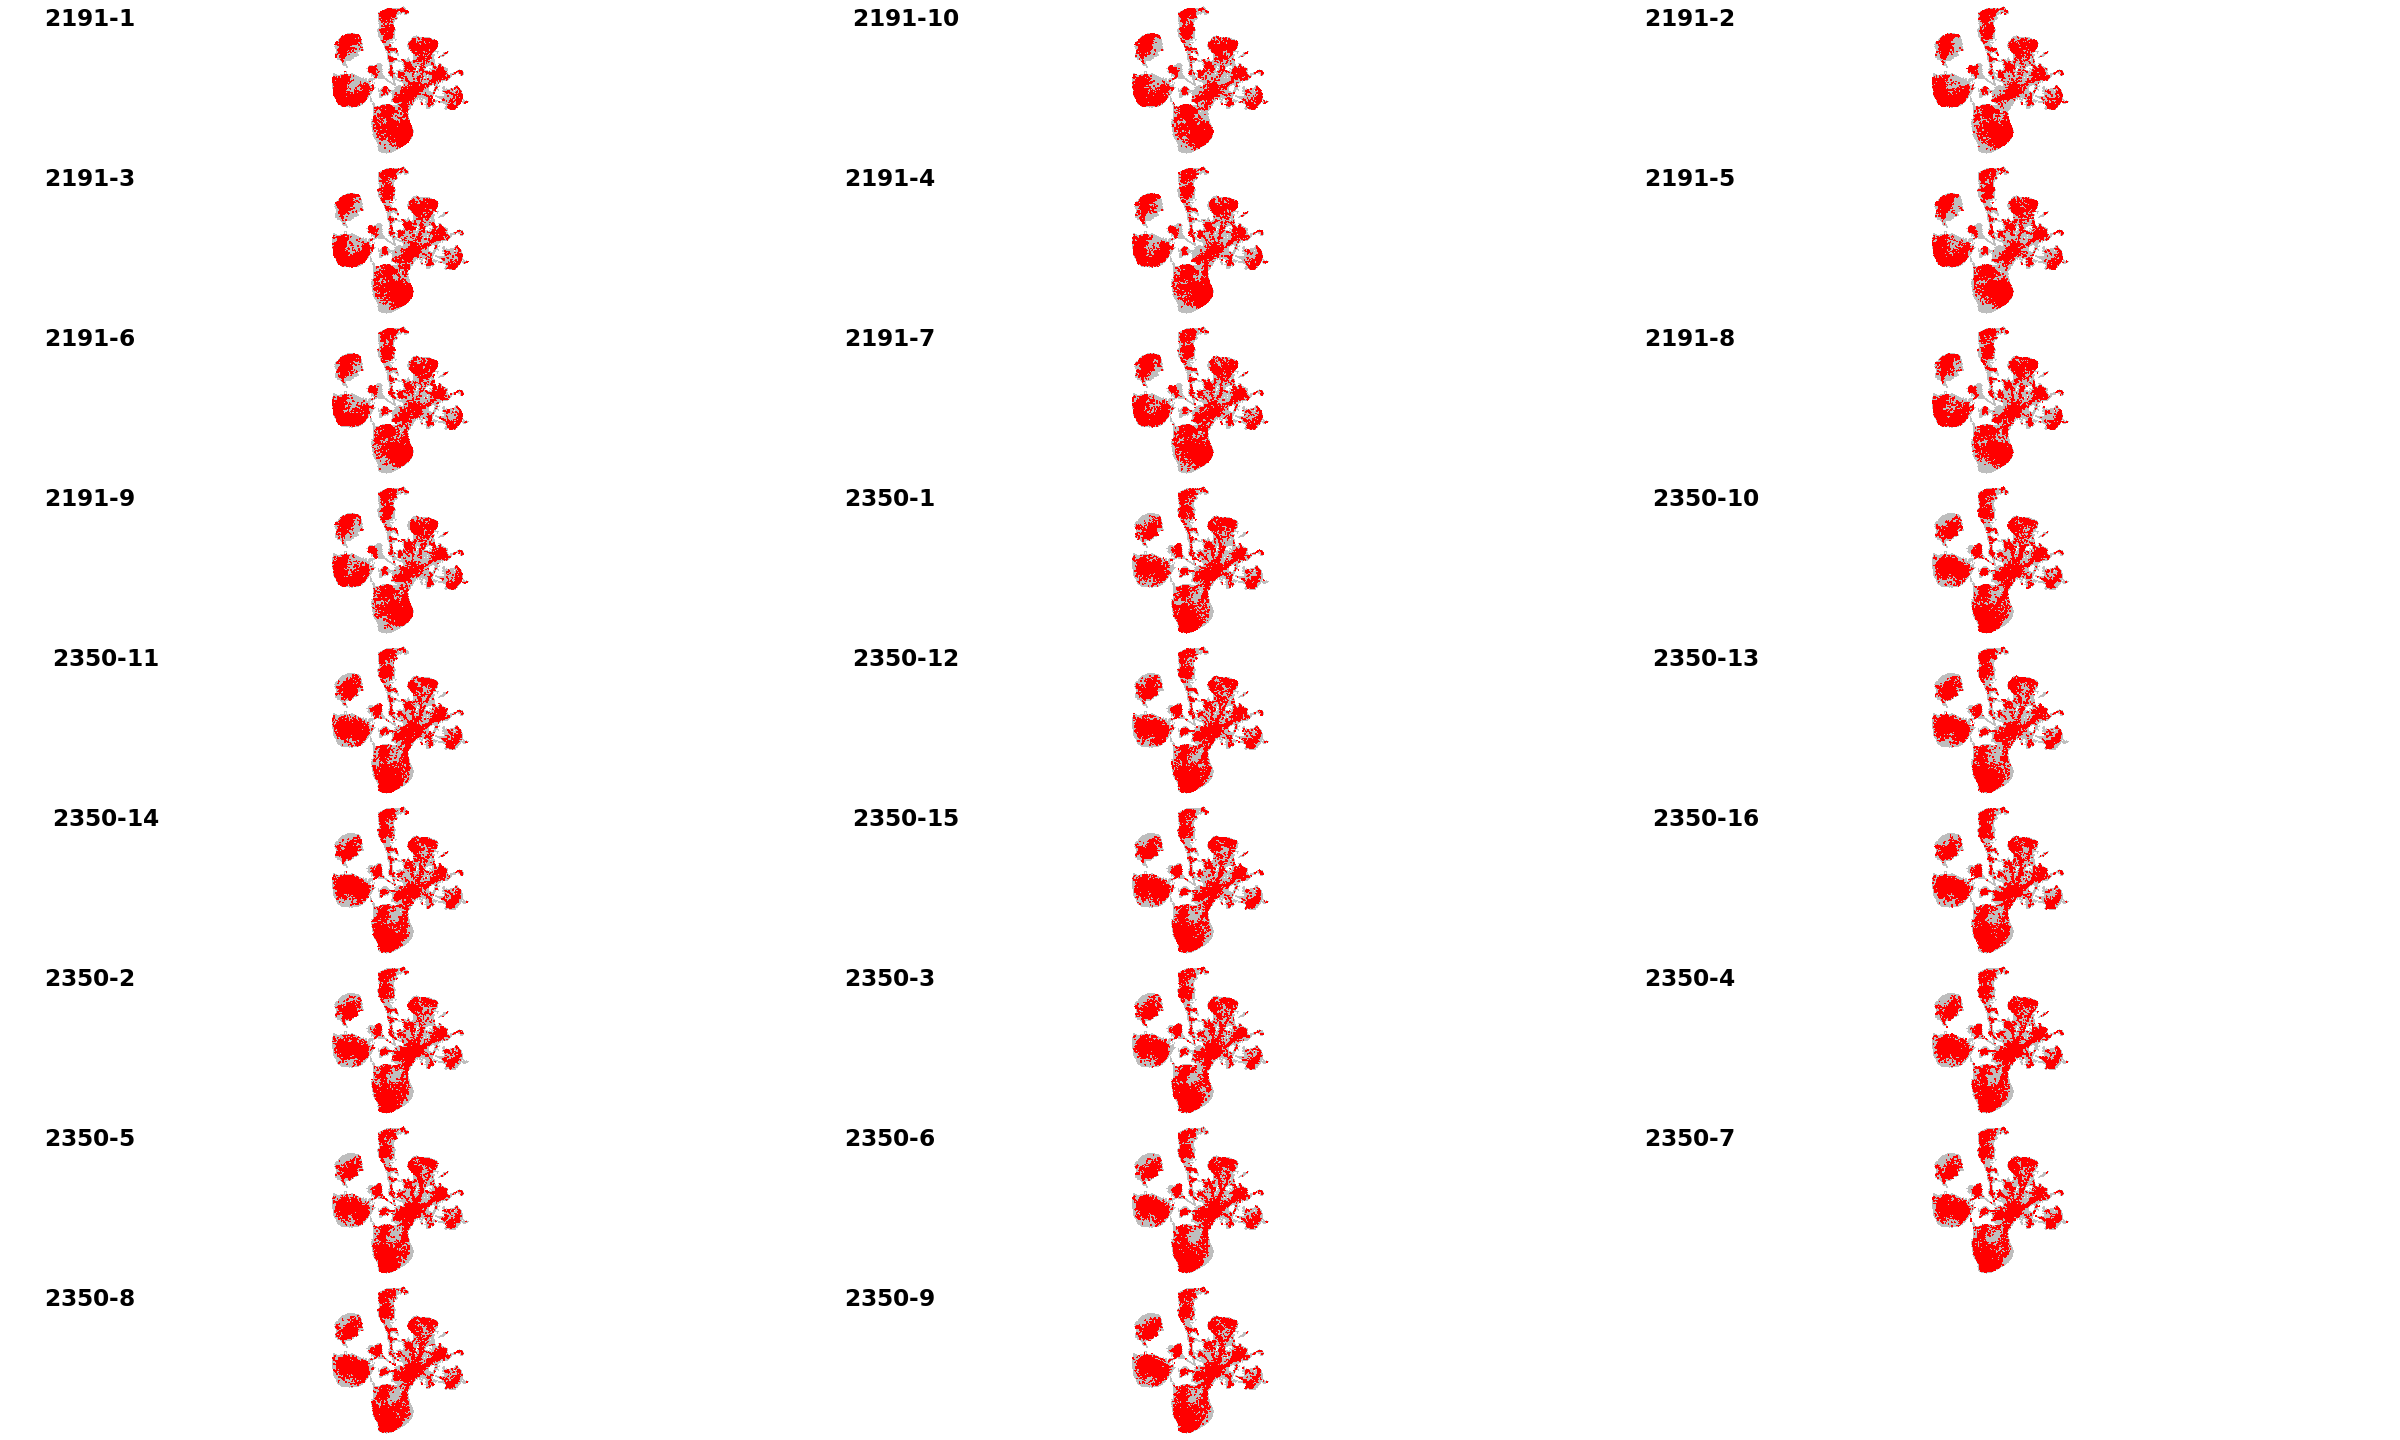

In [13]:
options(repr.plot.width=20, repr.plot.height=12)
myHighlightDimPlot(seurat, highlightBy="libId", showAllPoints=T, size=0.2, ncol=as.integer(sqrt(length(unique(seurat$libId))/2)))




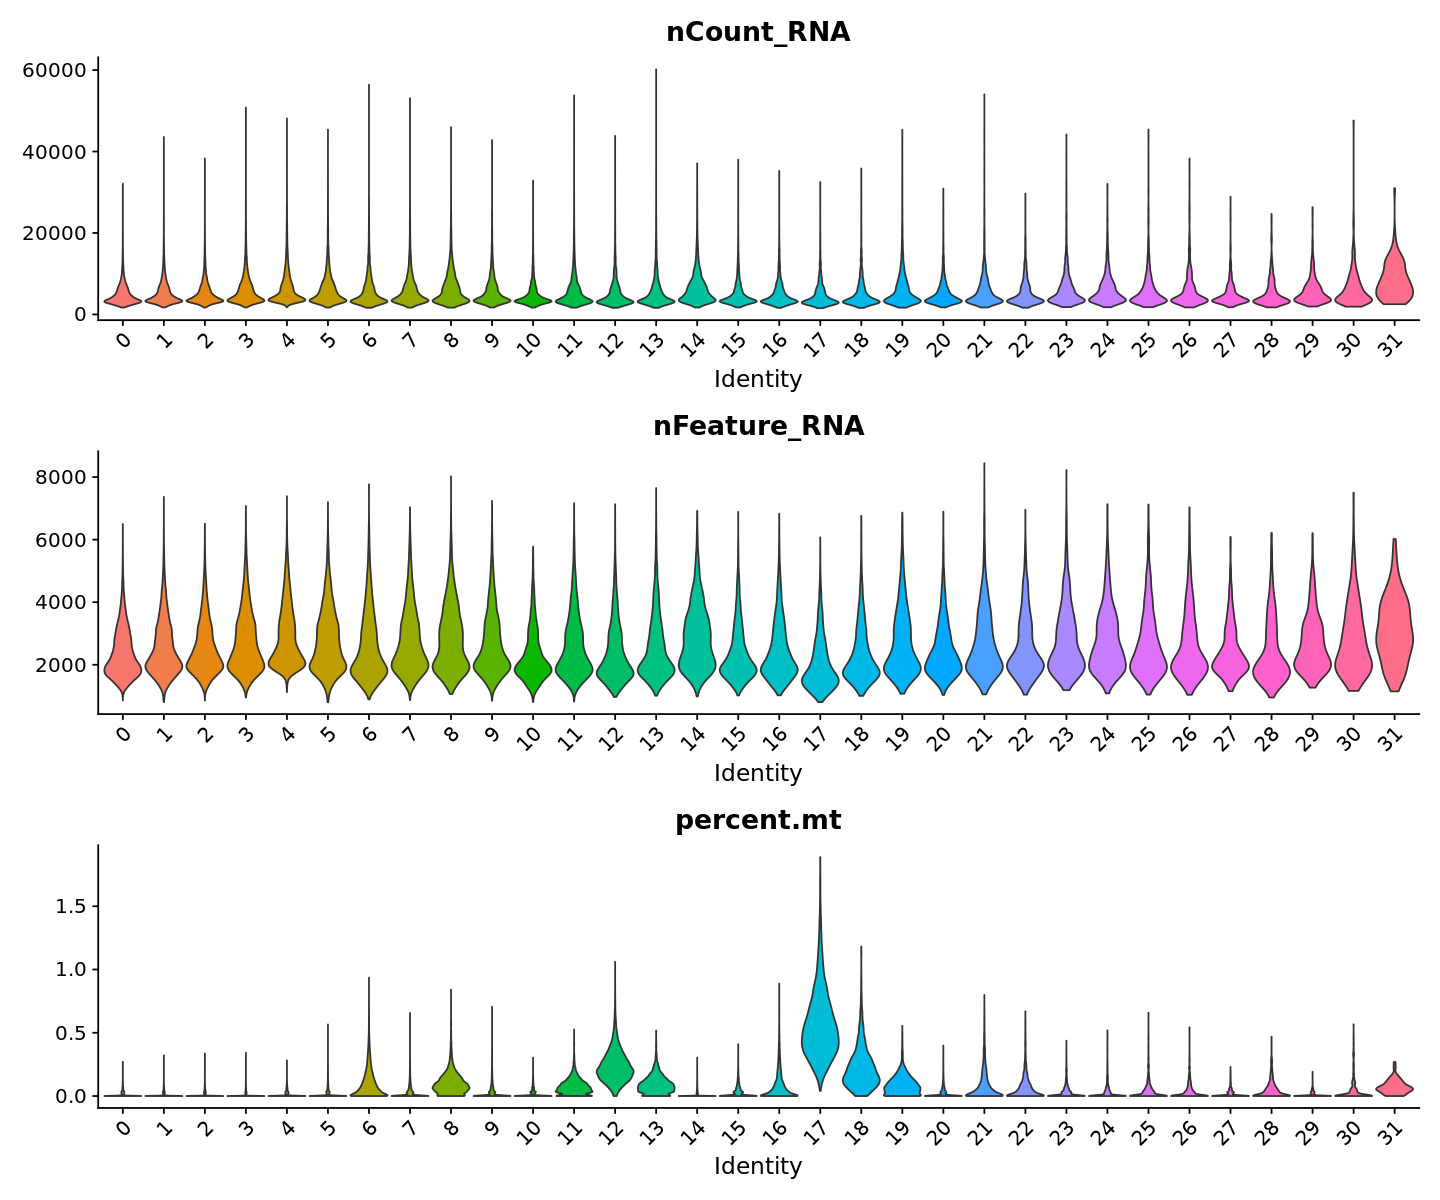

In [16]:
options(repr.plot.width=12, repr.plot.height=10)
Idents(seurat) = "seurat_clusters"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

Warning message in FetchData.Seurat(object = object, vars = features, cells = cells):
"The following requested variables were not found: Dlx6-As1, Zmydn10, Alpha-Sma, Pdgfralpha, Vecad, Cd105, Cox4l2, Motch3, Cs3cr1"


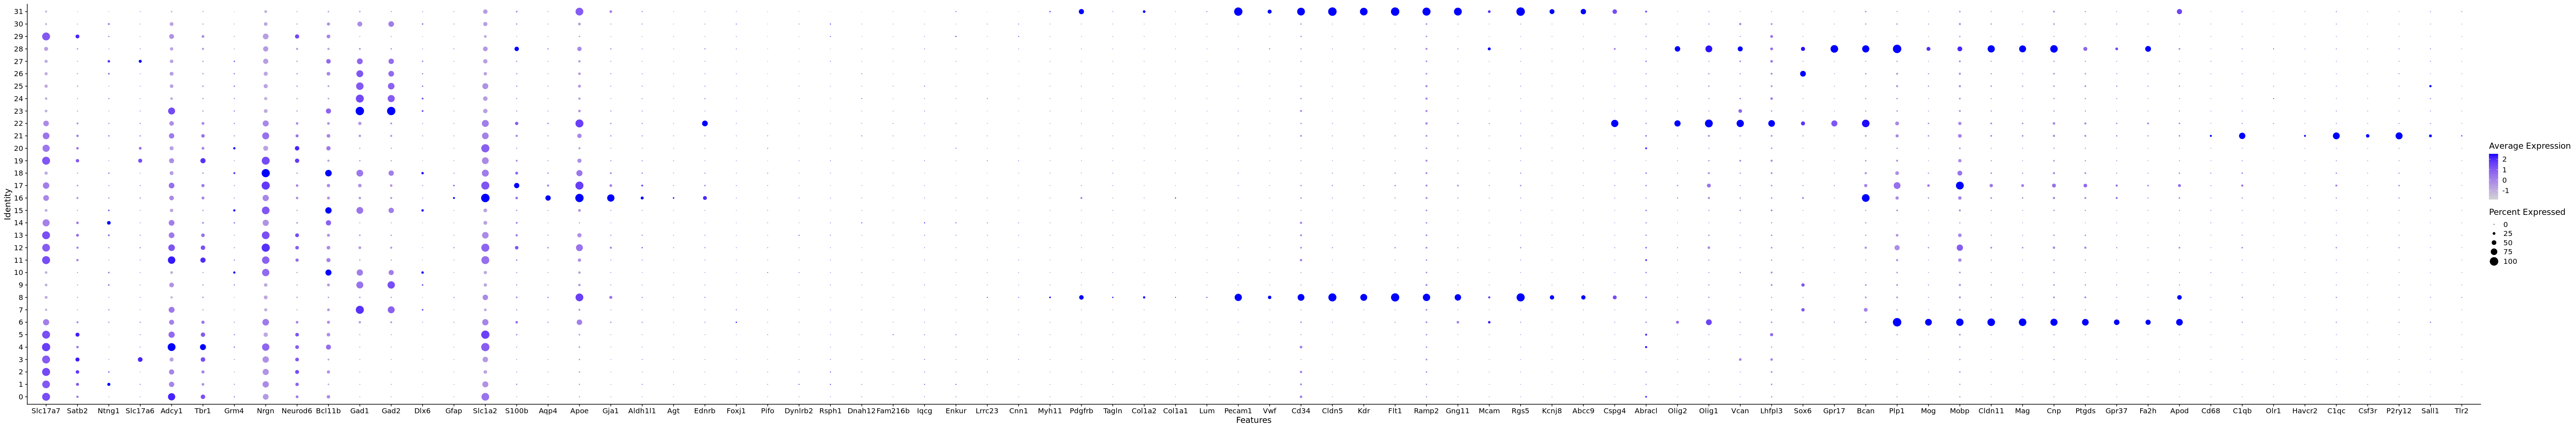

In [19]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2'# Microglia
)


selectMarkers=str_to_title(selectMarkers)

selectMarkers=selectMarkers[!duplicated(selectMarkers)]

options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)





In [26]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,2,3,4,5,14,19,29),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(7,9,23,24,25,26,27,30),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(16),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(6),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(8),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(22,28),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(21),]$class='Microglia'






In [27]:
table(seurat@meta.data$class)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          4604           7760         107202          21299           2155 
           OPC          Oligo      Uncertain 
          2355           9029          40933 

In [28]:
table(seurat@meta.data[seurat@meta.data$class=='Uncertain',]$seurat_clusters)




   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   0    0    0    0    0    0    0    0    0    0 6863 6720 6316 6060    0 5714 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
   0 3634 3000    0 2516    0    0    0    0    0    0    0    0    0    0  110 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



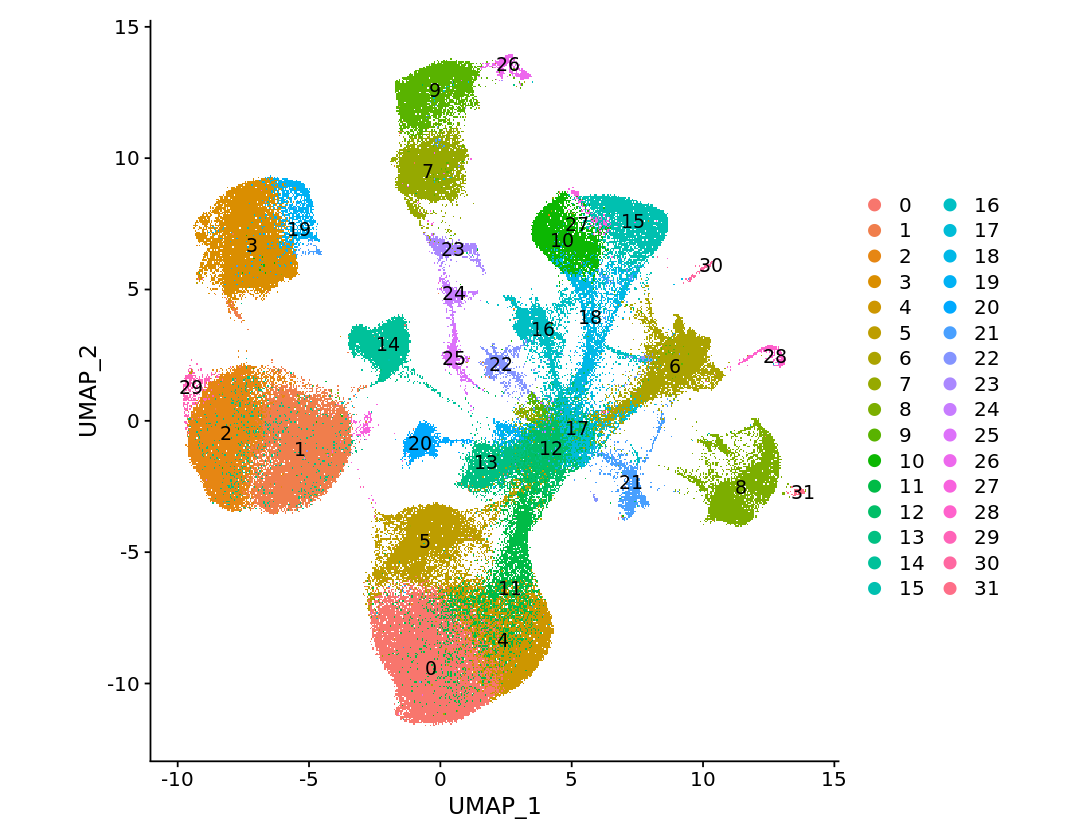

In [29]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T)+coord_fixed()



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



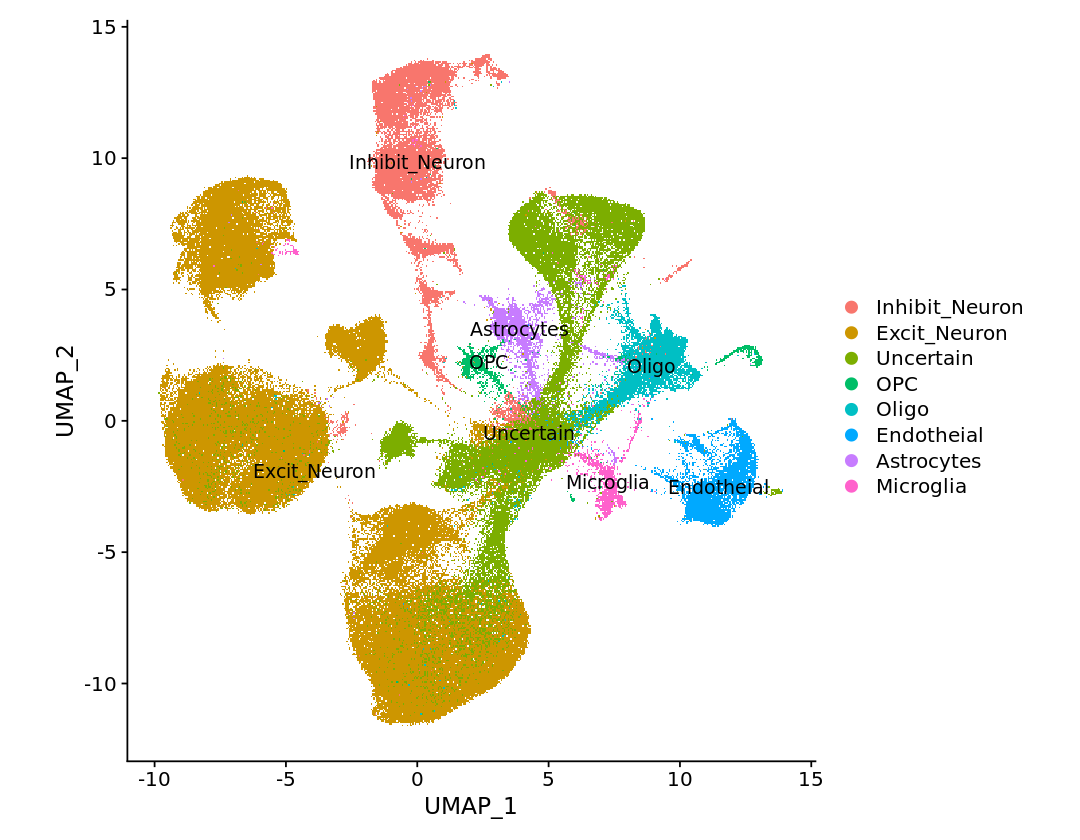

In [30]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T)+coord_fixed()

In [31]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	32291 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          3683           5000           5000           5000           1724 
           OPC          Oligo      Uncertain 
          1884           5000           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          3683           5000           5000           5000           1724 
           OPC          Oligo      Uncertain 
          1884           5000           5000 

In [32]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))




Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster OPC

Calculating cluster Oligo

Calculating cluster Uncertain



In [33]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            51            242              2             33             16 
           OPC          Oligo      Uncertain 
            33             46             16 

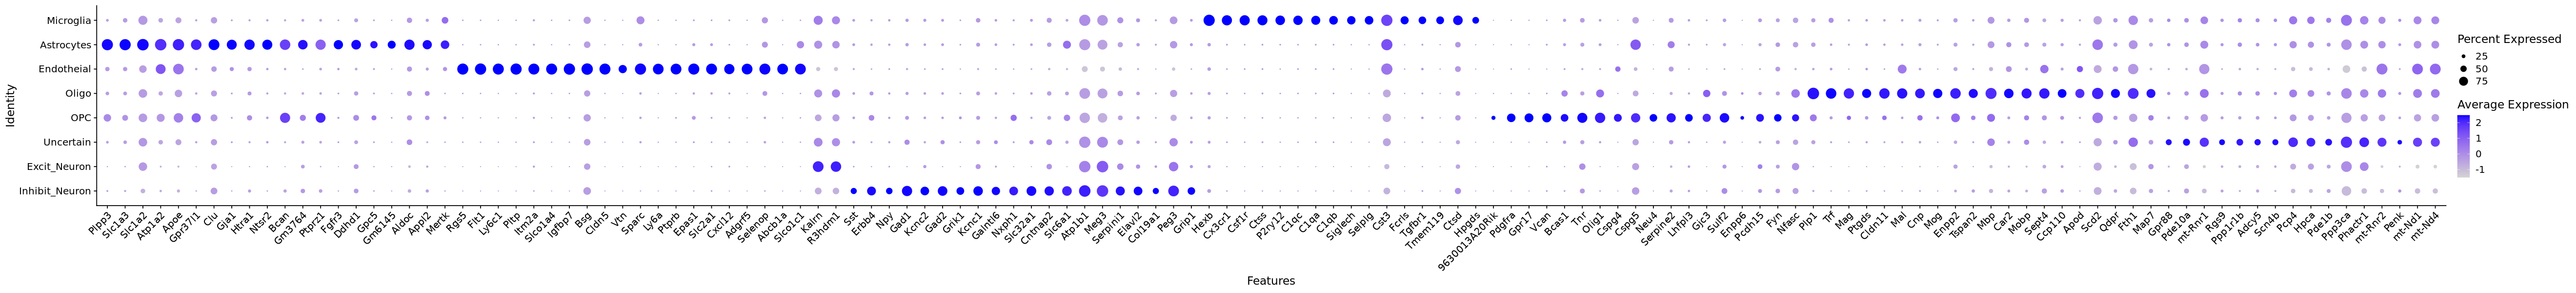

In [34]:

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [35]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:7, 1:8] 3627 14 5 42 19 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


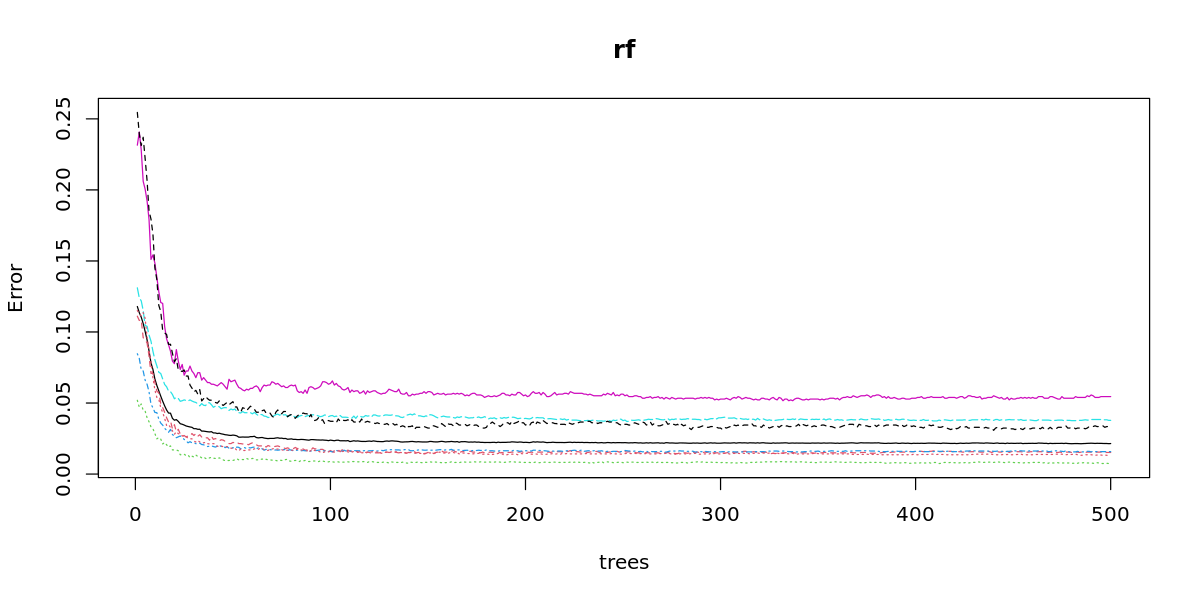

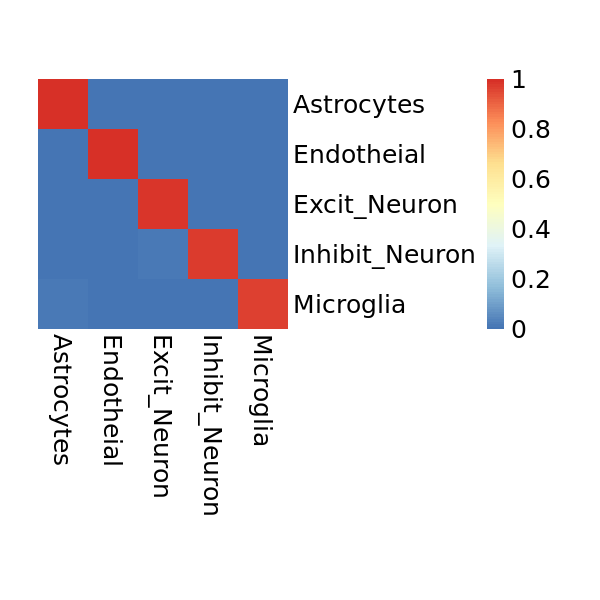

In [36]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:195337, 1:7] 0.008 0 0.002 0 0.02 0.04 0 0 0.01 0.014 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:195337] "2191-1_CELL6894_N1" "2191-1_CELL2974_N1" "2191-1_CELL39_N2" "2191-1_CELL4337_N1" ...
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId,maxPredClassScore,maxPredClass
<chr>,<dbl>,<chr>
2191-1_CELL6894_N1,0.786,Inhibit_Neuron
2191-1_CELL2974_N1,0.998,Inhibit_Neuron
2191-1_CELL39_N2,0.984,Excit_Neuron
2191-1_CELL4337_N1,0.970,Excit_Neuron
2191-1_CELL4465_N1,0.964,Inhibit_Neuron
2191-1_CELL2955_N1,0.920,Excit_Neuron


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1620  0.7780  0.9500  0.8495  0.9880  1.0000 

[1] TRUE

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



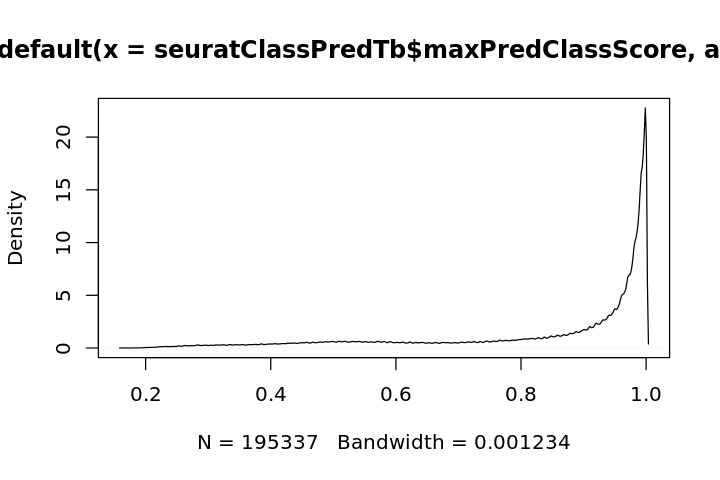

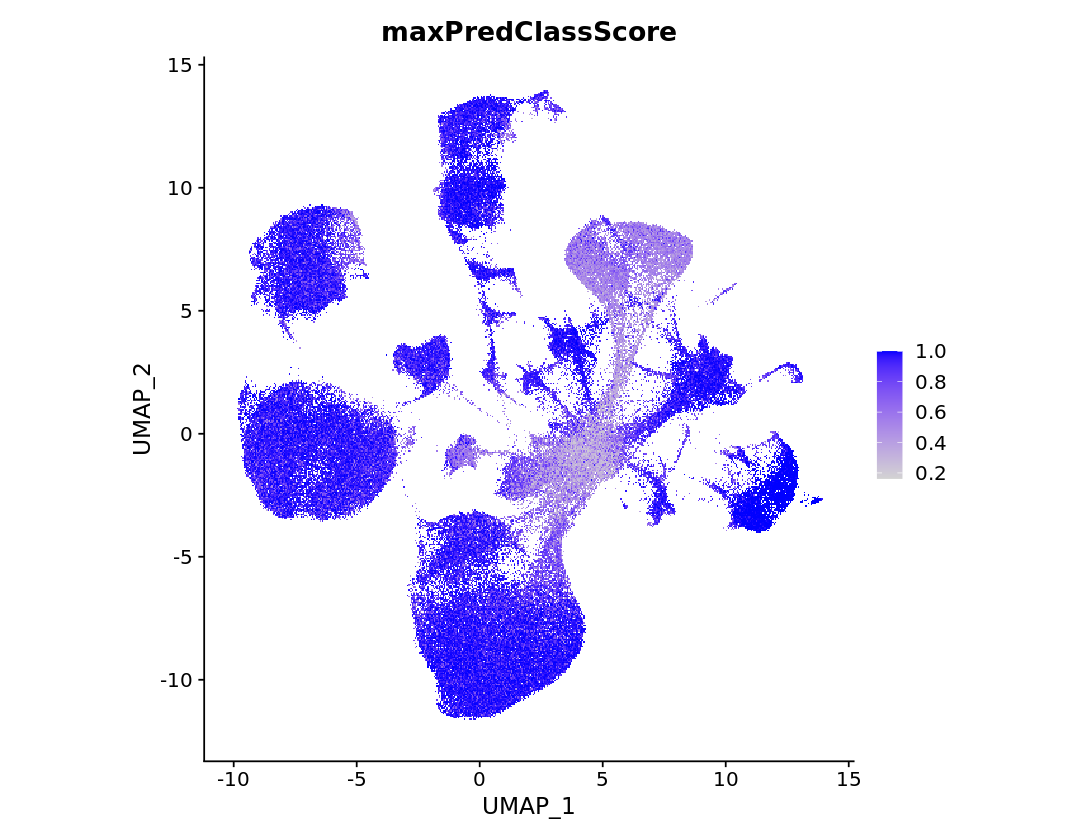

In [37]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore")+coord_fixed()

In [38]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)




Filt cell ratio: 0.734740474154922



In [39]:
table(classFiltSeurat$maxPredClass)


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          4477           7552         100047          18660           1913 
           OPC          Oligo 
          2058           8815 

In [40]:
saveRDS(classFiltSeurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/mouse_snrna_all_soupX_fil800_SCT_0524_anno.rds')



In [ ]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))


dataDir='/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/'
classFiltSeurat = readRDS(paste0(dataDir, "/mouse_snrna_all_soupX_fil800_SCT_0524_anno.rds"))

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0(dataDir, "/mouse_snrna_all_soupX_fil800_SCT_0524_anno_SCT.rds"))



In [ ]:
#!/bin/bash
#SBATCH -e /home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/err
#SBATCH -o /home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/out
#SBATCH -J 22222222222222
#SBATCH -p grande
#SBATCH --mem 500000
#SBATCH -n 2

Rscript /home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/anno_class_SCT.R

